# Imports 

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
from slowgrad.engine import SlowgradVar
from slowgrad.models import (
    SlowgradSequential, 
    SlowgradCrossEntropyLoss, 
    SlowgradLinear, 
    SlowgradSigmoid,
)
from slowgrad.optim import SlowgradAdam

## Moon dataset

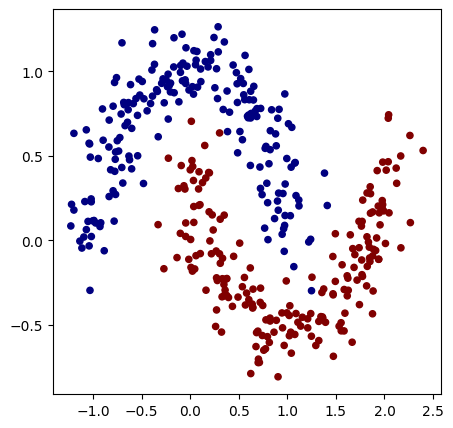

In [19]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=400, noise=0.15, random_state=420)

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet') 

### Model

In [20]:
model = SlowgradSequential([
    SlowgradLinear(2, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 16, bias=True),
    SlowgradSigmoid(),
    SlowgradLinear(16, 2, bias = True)
])
ce_loss = SlowgradCrossEntropyLoss()
optim = SlowgradAdam(model.parameters())
print(f'num params : {sum([p.data.numel() for p in model.parameters()])}')

num params : 626


In [21]:
x_data = torch.tensor(X, dtype=torch.float)
y_data = (torch.tensor(y)) 
y_data = F.one_hot(y_data, num_classes=2).type(torch.float)

def get_batch(x_data, y_data, batch_size):
    idx = np.random.choice(np.arange(x_data.shape[0]), size=batch_size, replace=False)
    x_batch, y_batch = x_data[idx], y_data[idx]
    return SlowgradVar(x_batch), SlowgradVar(y_batch)

def get_acc_and_ce(x_data, y_data):
    x, y = get_batch(x_data, y_data, x_data.shape[0])

    out = model(x)
    loss = ce_loss(out, y)

    pred, true = out.data, y.data
    pred = F.softmax(pred, dim=-1)
    pred = torch.argmax(pred, dim=-1)
    true = torch.argmax(true, dim=-1)
    acc = torch.sum(pred == true).item() / pred.shape[0]
    return f'loss:{loss.data.item():.2f}, acc:{acc:.2f}'

In [22]:
def train(model, data, epochs, batch_size, optim, metrics):
    x_data, y_data = data
    for epoch in range(epochs):

        optim.zero_grad()

        x_batch, y_batch = get_batch(x_data, y_data, batch_size = batch_size)

        out = model(x_batch)
        loss = ce_loss(out, y_batch)

        loss.backward()
        optim.step()

        if epoch % 100 == 0:
            print(f'[{epoch}/{epochs}] {metrics(x_data, y_data)}')

In [ ]:
epochs = 5000
batch_size = 16

train(model, (x_data, y_data), epochs, batch_size, optim, get_acc_and_ce)

(-1.8061451709002805, 2.1938548290997195)

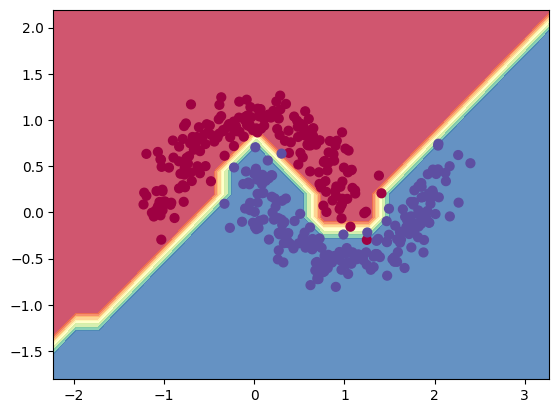

In [24]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

Xmesh = torch.tensor(Xmesh, dtype=torch.float)
inputs = SlowgradVar(Xmesh)
scores = torch.argmax(F.softmax(model(inputs).data, dim=-1), dim=-1)

Z = np.array(scores).reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())